## Submitted by:
### Yash Gangrade
### u1143811
### MS in Computing 

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage
import subprocess
import persim
import persim.plot
import tadasets
import ripser
from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from PIL import Image
from collections import Counter
import sklearn_tda as tda
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

Gudhi not found--GraphInducedComplex not available


# Part 1 - Comparison of Barcodes

### Utility functions to read the image and apply boundary filtration

In [2]:
def readImage(path):
    img = mpimg.imread(path)
    return img

def boundaryFiltration(image):
    distance = ndimage.distance_transform_edt(image)
    distance[distance != 1] = 0
    return distance, np.where(distance == 1)

In [3]:
# ## Driver code for getting the Point Clouds -- Original Data (without sampling)

# listOfImages = ["apple-", "car-0", "cellular_phone-", "children-", "cup-", "fork-", "hammer-", "pencil-"]

# for i in range(len(listOfImages)):
#     for j in range(1, 11):
#         path = "InputDataP1/" + listOfImages[i] + str(j) + ".gif"
#         img = readImage(path)
#         imgNp = np.asarray(img)
#         distance, coordinates = boundaryFiltration(imgNp)
#         tempArr = np.zeros((len(coordinates[0]), 2))
#         tempArr[:,0], tempArr[:,1] = coordinates[0], coordinates[1]
# #         tempArr[np.random.choice(tempArr.shape[0], 2, replace=False), :]
#         path = "OutputDataP1_PointCloud_NonSampled/" + listOfImages[i] + str(j) + "_PointCloud.txt"
#         np.savetxt(path, tempArr, fmt = "%0.6f")

# print("Point Cloud for each of the images stored in the files - Process Complete")

### Driver code for getting the Point Clouds - Sampled at 200 points

The list of images or classes used are 8. We are using 10 images from each class resulting in total of 80 images. The bottleneck distances and wassertian distance computation takes a lot of time and system also goes out of memory if we use the original barcodes. Therefore, to get rid of the issues, we sample 200 points from the boundary and then store it as point cloud. I have tried other numbers as well like 150, 250 etc. but 200 is an optimal number of points where you get a good boundary filtration. 

In [4]:
# list of images and also the classes that I used
listOfImages = ["apple-", "car-0", "cellular_phone-", "children-", "cup-", "fork-", "hammer-", "pencil-"]

## Read in the files from input data and then 
for i in range(len(listOfImages)):
    for j in range(1, 11):
        path = "InputDataP1/" + listOfImages[i] + str(j) + ".gif"
        img = readImage(path)
        imgNp = np.asarray(img)
        distance, coordinates = boundaryFiltration(imgNp)
        tempArr = np.zeros((len(coordinates[0]), 2))
        tempArr[:,0], tempArr[:,1] = coordinates[0], coordinates[1]

        ## Randomly sampling 200 points
        tempArr = tempArr[np.random.choice(tempArr.shape[0], 200, replace=False), :]

        path = "OutputDataP1_PointCloud_Sampled/" + listOfImages[i] + str(j) + "_PointCloud.txt"
        np.savetxt(path, tempArr, fmt = "%0.6f")

print("Point Cloud for each of the images stored in the files - Process Complete. Please find the Point Cloud data \
in OutputDataP1_Sampled folder")

Point Cloud for each of the images stored in the files - Process Complete. Please find the Point Cloud data in OutputDataP1_Sampled folder


### Computation of the Barcodes

Once we have the point clouds, next step is to compute the barcodes from the PointCloud Data. Here we also have to separate the bar codes in form of Dimension 0 and Dimension 1. To compute the barcode, I am calling the ripser command using the subprocess library. Next, we just write a parser to separate and store dimension 0 and dimension 1 features. The results can be found in OutputDataP1_Barcode_Sampled Folder. 

In [5]:
# Driver code for getting the bar codes separated by dimension 0 and 1 -- Sampled points

for i in tqdm(range(len(listOfImages))):
    for j in range(1, 11):
        cmd = "../ripser/ripser.exe OutputDataP1_PointCloud_Sampled/" + listOfImages[i] + str(j) + \
        "_PointCloud.txt --format point-cloud --dim 1"
        d = subprocess.run(cmd.split(), stdout=subprocess.PIPE)
        barcode = d.stdout.decode('utf-8').splitlines()
        separator1 = barcode.index("persistence intervals in dim 0:")
        separator2 = barcode.index("persistence intervals in dim 1:")

        featuresDim0 = barcode[separator1 + 1:separator2]
        featuresDim1 = barcode[separator2 + 1:]
        path0 = "OutputDataP1_Barcode_Sampled/" + listOfImages[i] + str(j) + "_Dim0.txt"
        path1 = "OutputDataP1_Barcode_Sampled/" + listOfImages[i] + str(j) + "_Dim1.txt"

        with open(path0, 'w') as f:
            for item in featuresDim0:
                f.write("%s\n" % item)
        with open(path1, 'w') as f:
            for item in featuresDim1:
                f.write("%s\n" % item)

### Comparison of the Barcodes

Till this point, we have the barcodes, next step is to compare these different barcodes. Two methods that we are gonna use are the bottleneck and wassertian distance. To compute these distances, we are using in built functions from sklearn_tda library. After getting the distances, we are gonna project it to a 2D plane by using Dimensionality reduction techniques namely MDS and TSNE. 

__Note:__ Please follow the comments in the code to get the understanding of the works. 

In [6]:
## A utility function to get the persistence diagrams of all the images in the dataset. This function performs parsing
## and separation of the input into an array containing the same number of output rows as the input. 

def distanceUtil(path, flag):
    with open(path) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    if flag is True:
        last = len(content)
    else:
        last = len(content) - 1
    dgm = np.zeros(shape = (last, 2))
    
    for i in range(last):
        temp = content[i].replace("[", "").replace(")", "").split(",")
        dgm[i][0] = float(temp[0])
        dgm[i][1] = float(temp[1])
    return dgm

In [7]:
## Driver code for reading all the matrices from the Barcodes. dgmArr0 and dgmArr1 represents all the persistence diagrams for
## dimension 0 and 1 respectively. 

dgmArr0 = []
dgmArr1 = []

for i in range(len(listOfImages)):
    for j in range(1, 11):
        path = "OutputDataP1_Barcode_Sampled/" + listOfImages[i] + str(j) + "_Dim0.txt"
        dgmArr0.append(distanceUtil(path, False))
        path = "OutputDataP1_Barcode_Sampled/" + listOfImages[i] + str(j) + "_Dim1.txt"
        dgmArr1.append(distanceUtil(path, True))

In [8]:
## initializing the bottleneck and wassertian distances as 0 for both dimension 0 and 1

bottleneck_distances_dim0 = np.zeros(shape = (80, 80))
bottleneck_distances_dim1 = np.zeros(shape = (80, 80))
wassertian_distances_dim0 = np.zeros(shape = (80, 80))
wassertian_distances_dim1 = np.zeros(shape = (80, 80))

In [9]:
## Driver code for filling in the bottleneck distance matrix - dim 1 - by sklearn tda

for i in tqdm(range(80)):
    for j in (range(80)):
        bottleneck_distances_dim1[i][j] = tda.bottleneck(dgmArr1[i], dgmArr1[j])

In [10]:
## Driver code for filling in the bottleneck distance matrix - dim 0 - by sklearn tda

for i in tqdm(range(80)):
    for j in (range(80)):
        bottleneck_distances_dim0[i][j] = tda.bottleneck(dgmArr0[i], dgmArr0[j])

In [11]:
## Driver code for filling in the wassertian distance matrix - dim 0 - by sklearn tda

for i in tqdm(range(80)):
    for j in (range(80)):
        wassertian_distances_dim0[i][j] = tda.wasserstein(dgmArr0[i], dgmArr0[j])

In [12]:
## Driver code for filling in the wassertian distance matrix - dim 1 - by sklearn tda

for i in tqdm(range(80)):
    for j in (range(80)):
        wassertian_distances_dim1[i][j] = tda.wasserstein(dgmArr1[i], dgmArr1[j])

In [168]:
## Saving these matrices as a txt file for any future analysis required

path = "OutputDataP1_Distance/BottleneckDistanceDim1_Sampled.txt"
np.savetxt(path, bottleneck_distances_dim1, fmt = "%0.6f")
path = "OutputDataP1_Distance/BottleneckDistanceDim0_Sampled.txt"
np.savetxt(path, bottleneck_distances_dim0, fmt = "%0.6f")
path = "OutputDataP1_Distance/WassertianDistanceDim1_Sampled.txt"
np.savetxt(path, wassertian_distances_dim1, fmt = "%0.6f")
path = "OutputDataP1_Distance/WassertainDistanceDim0_Sampled.txt"
np.savetxt(path, wassertian_distances_dim0, fmt = "%0.6f")

In [13]:
## Next we define a function which takes the distance matrix as the input and the method which you want to use 
## for dimensionality reduction. We return the transformed distance matrix. Also since the distances matrix are not
## symmetric because the diagonally opposite values vary by some small amount. So to make it symmetric for MDS and TSNE, 
## we are temporarily averaging out the values with the transpose. This is just one of the ways to make it symmetric.
## other way is to compute only upper triangular or lower triangular and copy value over to the other. 

def computeDimReduction(method, distances):
    distances = (distances + distances.T)/2
    distances_transformed = np.empty(shape=(80, 2))
    if method == 'MDS':
        distances_transformed = MDS(n_components=2, dissimilarity='precomputed').fit_transform(distances)
    elif method == 'TSNE':
        distances_transformed = TSNE(n_components=2, metric='precomputed').fit_transform(distances)
    return distances_transformed

In [14]:
## Compute the transformed distances using MDS and TSNE for dimension 1
bottleneck_distances_dim1_MDS = computeDimReduction('MDS', bottleneck_distances_dim1)
bottleneck_distances_dim1_TSNE = computeDimReduction('TSNE', bottleneck_distances_dim1)
wassertian_distances_dim1_MDS = computeDimReduction('MDS', wassertian_distances_dim1)
wassertian_distances_dim1_TSNE = computeDimReduction('TSNE', wassertian_distances_dim1)

In [15]:
## Compute the transformed distances using MDS and TSNE for dimension 0
bottleneck_distances_dim0_MDS = computeDimReduction('MDS', bottleneck_distances_dim0)
bottleneck_distances_dim0_TSNE = computeDimReduction('TSNE', bottleneck_distances_dim0)
wassertian_distances_dim0_MDS = computeDimReduction('MDS', wassertian_distances_dim0)
wassertian_distances_dim0_TSNE = computeDimReduction('TSNE', wassertian_distances_dim0)

In [16]:
## Utility function to project the MDS and TSNE points and color them according to the classes. 
def plotScatter(distances):
    bd_x = np.zeros(len(distances))
    bd_y = np.zeros(len(distances))

    for i in range(len(distances)):
        bd_x[i] = distances[i][0]
        bd_y[i] = distances[i][1]

    labelArray = np.zeros(80)
    ## LabelArray contains the labels for each of the image. 
    
    label = 0
    for i in range(len(labelArray)):
        if i % 10 == 0:
            label += 1
        labelArray[i] = label

    plt.scatter(bd_x, bd_y, c = labelArray, cmap = "tab10")
    plt.show()

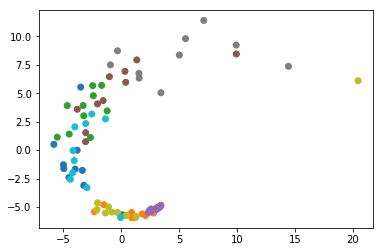

MDS - Bottleneck Distance Dim 0



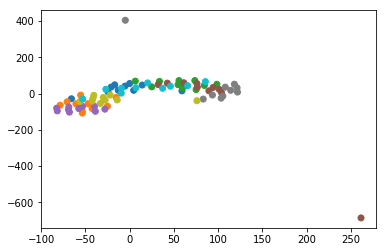

TSNE - Bottleneck Distance Dim 0



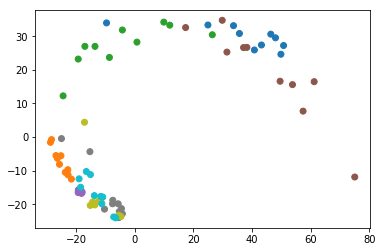

MDS - Bottleneck Distance Dim 1



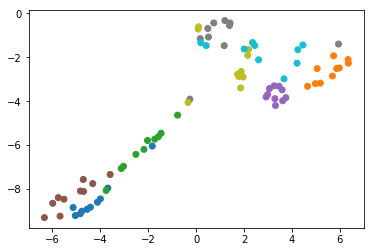

TSNE - Bottleneck Distance Dim 1



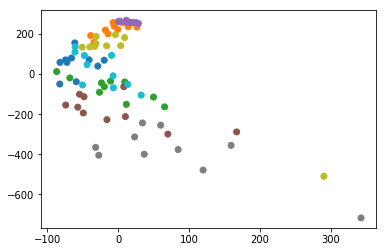

MDS - Wassertian Distance Dim 0



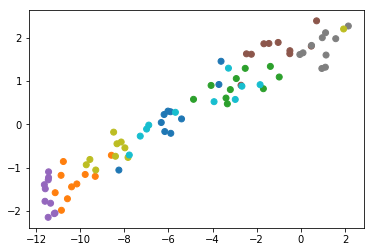

TSNE - Wassertian Distance Dim 0



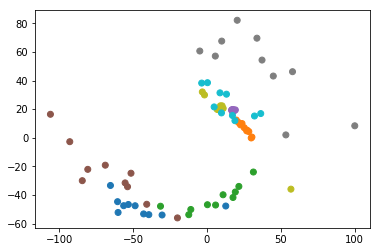

MDS - Wassertian Distance Dim 1



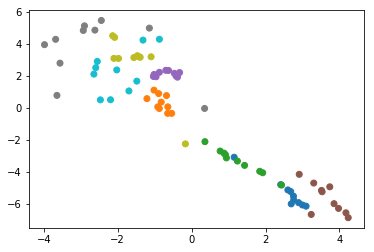

TSNE - Wassertian Distance Dim 1



In [45]:
# Plots for Bottleneck Distances - Dim 0 and 1

plotScatter(bottleneck_distances_dim0_MDS)
print("MDS - Bottleneck Distance Dim 0\n")
plotScatter(bottleneck_distances_dim0_TSNE)
print("TSNE - Bottleneck Distance Dim 0\n")
plotScatter(bottleneck_distances_dim1_MDS)
print("MDS - Bottleneck Distance Dim 1\n")
plotScatter(bottleneck_distances_dim1_TSNE)
print("TSNE - Bottleneck Distance Dim 1\n")

# Plots for Wassertian Distances - Dim 0 and 1
plotScatter(wassertian_distances_dim0_MDS)
print("MDS - Wassertian Distance Dim 0\n")
plotScatter(wassertian_distances_dim0_TSNE)
print("TSNE - Wassertian Distance Dim 0\n")
plotScatter(wassertian_distances_dim1_MDS)
print("MDS - Wassertian Distance Dim 1\n")
plotScatter(wassertian_distances_dim1_TSNE)
print("TSNE - Wassertian Distance Dim 1\n")

### Passing raw images to MDS and TSNE

Here, we are passing the raw images to MDS and TSNE functions. But for that, we need to process the images a bit. First thing is to resize all the 80 images to same size. To get the resizing coordinates, I first found out the maximum dimension in X and Y dimension of the image. In my dataset, it's 720 px so we used an online __[tool](https://bulkresizephotos.com/)__ to resize all the images to 730 * 730 px (extra 10 px to make sure no points are at the boundary). This resizing requires the use of padding by black pixels or 0 values. If we use white pixels for padding, it would result in extra dimension 0 and 1 features. 

Then, we read and store all the 80 images into a numpy array (named 'imgArray'). This is an array of arrays and it has dimensions of (80, 730, 730). Then, we flatten out all the images in this array by using the method or row by row concatenation discussed in the class. Finally, we call the MDS and TSNE functions over the flattened array and plot the results on a 2D plane.

In [18]:
### Find the maximum lenX and lenY for all the images.
### The maximum value will be used to resize the images
lenX = 0
lenY = 0
for i in range(len(listOfImages)):
    for j in range(1, 11):
        path = "InputDataP1/" + listOfImages[i] + str(j) + ".gif"
        img = readImage(path)
        imgNp = np.asarray(img)
        if lenX < imgNp.shape[0]:
            lenX = imgNp.shape[0]
        if lenY < imgNp.shape[1]:
            lenY = imgNp.shape[1]

In [19]:
print(lenX, lenY)

650 720


In [20]:
## this function converts the rgb channels of the images to a grayscale value. 

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [21]:
## Used online resizer tool to add padding to convert all images to 730 x 730 pixels
imgArray = []

for i in range(len(listOfImages)):
    for j in range(1, 11):
        path = "InputDataP1_resize/" + listOfImages[i] + str(j) + ".jpg"
        img = readImage(path)
        img = rgb2gray(img)
        imgNp = np.asarray(img)
        imgArray.append(imgNp)

imgArray = np.asarray(imgArray) 

In [22]:
imgArray.shape

(80, 730, 730)

In [23]:
imgArray_flatten = [ np.empty(730*730) for x in range(80)]
print(imgArray_flatten[0].shape)

(532900,)


In [24]:
for i in tqdm(range(len(imgArray))):
    imgArray_flatten[i] = imgArray[i].flatten()

In [25]:
# path = "OutputDataP1_Distance/flattenImgArray.txt"
# np.savetxt(path, imgArray_flatten, fmt = "%0.6f")

In [26]:
## Running the flattened array on MDS and TSNE and produce results for part 1 - 3

## Compute the transformed distances using MDS
x = imgArray_flatten
imgArray_MDS = MDS(n_components=2).fit_transform(x)
imgArray_TSNE = TSNE(n_components = 2).fit_transform(x)

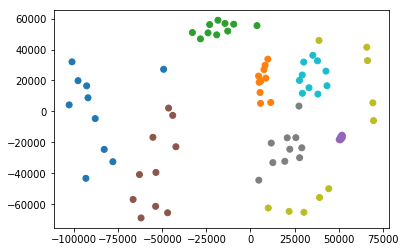

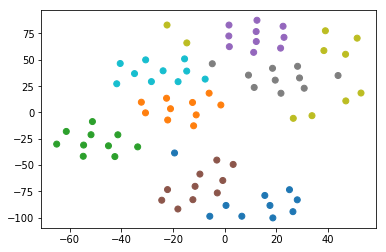

In [27]:
plotScatter(imgArray_MDS)
plotScatter(imgArray_TSNE)

### Comparison between the MDS and TSNE plots of Raw Images vs plots from Bottleneck and Wassertian Distance

We get 8 different plots in Part 1.1 and 1.2 for dimension 0 and 1 respectively. From all the plots of MDS and TSNE, we can observe that the TSNE produces a bit better results than MDS in terms of clustering of the points. Also, we can observe that the output plots from the raw images are also slightly better than the plots we get from bottleneck and wassertian distance. One more thing to be observed is for dimension 0 and MDS, both wassertian distance and bottleneck distances produces plots which are not clustered so well compared to TSNE.  

# Part 2 - Classification

### Labels creation

Initialize labels for the input data points. In this case it will be 1 label each for the 80 images. For the 8 classes, we will have 1 label for each image classes. Eg. apple will have label 0, car will have label 1 and so on. 

For the 4 classes case, we are simply allocating a single label to the combination of two image classes. For example, the "apple" and "car " have same labels. The assignment of equal labels to two classes is finalized by looking at the persistence diagram of the images and see which classes are the closest ones and assign them the same label

In [28]:
# labels8 is an array of labels when there are 8 classes
labels8 = np.zeros(80)
# labels4 is an array of labels when there are 4 classes
labels4 = np.zeros(80)

counter = -1
for i in range(80):
    if i % 10 == 0:
        counter += 1
    labels8[i] = int(counter)

counter = -1
for i in range(80):
    if i % 20 == 0:
        counter += 1
    labels4[i] = int(counter)
    
labels8 = labels8.astype(int)
labels4 = labels4.astype(int)

In [29]:
labels8

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [30]:
labels4

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

## Classifying the images - Part 2.1

Here we are using the flattened image array to get the train, test, training labels, testing labels after splitting the original data by 80% training and 20% testing ratio. For each of the classes, first 8 images will be considered a part of the training set and the rest 2 images will be added to the training set. Then, we are using the linear SVC kernel to fit and calculate the accuracy of the prediction. We get very high accuracy of prediction, nearly about 93.75% most of the times. It sometimes fluctuates to 80% or 100% depending on the random train_test_split we have. 

### Run for 8 classes/labels

In [31]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(imgArray_flatten, labels8, test_size = 0.2, stratify = labels8)

In [32]:
svm = SVC(kernel = 'linear')
svm.fit([image for image in X_train1], Y_train1)
svm.score([image for image in X_test1], Y_test1)

0.9375

### Run for 4 classes/labels

In [33]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(imgArray_flatten, labels8, test_size = 0.2, stratify = labels4)

In [34]:
svm = SVC(kernel = 'linear')
svm.fit([image for image in X_train1], Y_train1)
svm.score([image for image in X_test1], Y_test1)

1.0

## Persistence Scale Space Kernels

To perform the classification using Persistence Scale Space Kernels, we use the scikitlearn_tda library. There's an inbuilt function called PersistenceScaleSpaceKernel(). We first split the training and testing data from the persistence diagram array i.e. dgmArr1 and dgmArr0. We then use SVC with 'precomputed' options to compute the fit and score of the Scale Space Kernel. We run this code first for 8 classes/labels and for both 0 and 1 dimensional features. We then perform similar runs for 4 classes/labels. Accracy of predictions are reported with each of the running cell. 

We get good accuracies for both the runs with 8 and 4 labels respectively. For dimension 1 in both the cases, we get fluctuating accuracies centered around 62.5% with mostly on high side being 81%. Similarly for dimension 0, we get relatively lower accuracies centered around 43.75%.

### Run for 8 classes/labels

In [35]:
## For Dimension 1
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(dgmArr1, labels8, test_size = 0.2, stratify = labels8)
clf = SVC(kernel = 'precomputed')
SpaceKernel = tda.PersistenceScaleSpaceKernel()

trainingKernel = SpaceKernel.fit(X_train1).transform(X_train1)
testingKernal = SpaceKernel.transform(X_test1)
clf.fit(trainingKernel, Y_train1)
clf.score(testingKernal, Y_test1)

0.8125

In [36]:
## For Dimension 0
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(dgmArr0, labels8, test_size = 0.2, stratify = labels8)
clf = SVC(kernel = 'precomputed')
SpaceKernel = tda.PersistenceScaleSpaceKernel()

trainingKernel = SpaceKernel.fit(X_train1).transform(X_train1)
testingKernal = SpaceKernel.transform(X_test1)
clf.fit(trainingKernel, Y_train1)
clf.score(testingKernal, Y_test1)

0.625

### Run for 4 classes/labels

In [37]:
## For Dimension 1
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(dgmArr1, labels4, test_size = 0.2, stratify = labels4)
clf = SVC(kernel = 'precomputed')
SpaceKernel = tda.PersistenceScaleSpaceKernel()

trainingKernel = SpaceKernel.fit(X_train1).transform(X_train1)
testingKernal = SpaceKernel.transform(X_test1)
clf.fit(trainingKernel, Y_train1)
clf.score(testingKernal, Y_test1)

0.875

In [38]:
## For Dimension 0
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(dgmArr0, labels4, test_size = 0.2, stratify = labels4)
clf = SVC(kernel = 'precomputed')
SpaceKernel = tda.PersistenceScaleSpaceKernel()

trainingKernel = SpaceKernel.fit(X_train1).transform(X_train1)
testingKernal = SpaceKernel.transform(X_test1)
clf.fit(trainingKernel, Y_train1)
clf.score(testingKernal, Y_test1)

0.375

## Persistence Images classifications

Similar to the previous case, here also we perform the experiments with 8 and 4 classes/labels resp. First, we compute the persistence images from the persistence diagrams array i.e dgmArr0 or dgmArr1 using the PersImage function implemented in persim. Once, we have the persistence diagram array, we split the training and testing data from the persistence diagram array. After that, we use linear SVC kernel to perform classification. 

We get good accuracies for both the runs with 8 labels respectively. In the case of 8 labels, for dimension 1 in both the cases, we get fluctuating accuracies centered around 56.25% with high being 93.75% and low being around 43%. Similarly for dimension 0, we get relatively lower accuracies centered around 37.5%. In the case of 4 labels, for dimension 1, we get varying accuracies on each run centred around 37.5% and for dimension 0, we get varying accuracies centered around 25%. 

In [39]:
## Get the persistence images from the persistence diagrams array using the PersImage function in persim

persDgm1 = []
persDgm0 = []

for i in range(len(dgmArr1)):
    persDgm1.append(persim.PersImage(verbose=False).transform(dgmArr1[i]))
    persDgm0.append(persim.PersImage(verbose=False).transform(dgmArr0[i]))

### Running for 8 classes/labels

In [40]:
## Running for dimension 0 persistence diagrams
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(persDgm0, labels8, test_size = 0.2, stratify = labels8)
svm = SVC(kernel = 'linear')
svm.fit([image.flatten() for image in X_train1], Y_train1)
svm.score([image.flatten() for image in X_test1], Y_test1)

0.5625

In [41]:
## Running for dimension 1 persistence diagrams
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(persDgm1, labels8, test_size = 0.2, stratify = labels8)
svm = SVC(kernel = 'linear')
svm.fit([image.flatten() for image in X_train1], Y_train1)
svm.score([image.flatten() for image in X_test1], Y_test1)

0.6875

### Running for 4 classes/labels

In [42]:
## Running for dimension 0 persistence diagrams
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(persDgm0, labels8, test_size = 0.2, stratify = labels4)
svm = SVC(kernel = 'linear')
svm.fit([image.flatten() for image in X_train1], Y_train1)
svm.score([image.flatten() for image in X_test1], Y_test1)

0.3125

In [43]:
## Running for dimension 1 persistence diagrams
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(persDgm1, labels8, test_size = 0.2, stratify = labels4)
svm = SVC(kernel = 'linear')
svm.fit([image.flatten() for image in X_train1], Y_train1)
svm.score([image.flatten() for image in X_test1], Y_test1)

0.125

The table below summarizes all the accuracies. But please note, these are just an snapshot at a point of time, real accuracies fluctuates with every run since the testing and training data is changed on every run.

|      | Accuracy ( 8 Labels) - Dim 0 | Accuracy ( 4 Labels) - Dim 0  | Accuracy ( 8 Labels) - Dim 1 | Accuracy ( 4 Labels) - Dim 1 |
|------|----------------------|----------------------|
|   Image Classification (Linear Kernel)  |    93.75%             |      100%                |    93.75%             |      100%                |
|   Persistence Space Scale Kernel    |    43.75%             |      43.75%                |   68.75%             |      81.25%                |
|   Persistence Image Classification    |    37.5%             |      25%                |   56.25%             |      37.5%                |

## Appendix

### File Folders

Full Data -> Full original MPEG-7 Data

InputDataP1 -> contains the 80 input image files which is being used for the processing

InputDataP1_resize -> contains the resized 80 input image files (each image is now 730*730 px)

OutputDataP1_PointCloud_NonSampled -> Point cloud from the original image. No sampling is done here. I am not using it in this code but just included it as a reference.

OutputDataP1_PointCloud_Sampled -> Due to memory and timing issues, we sample 200 points from the data as we discussed earlier. I am using this data to generate barcodes. 

OutputP1_Barcode -> Barcodes or Persistence Diagrams for the original image. Not using it in the code. 

OutputDataP1_Barcode_Sampled -> Barcodes or Persistence Diagrams for the sampled image.

OutputDataP1_Distance -> Contains the bottleneck and wassertian distance matrices for dimension 0 and 1 resp. It also contains the flattened image array of size 80 * 532900.

Figures -> contains the plots from this ipynb

### Python Libraries used

Following libraries were used in their latest versions: numpy, matplotlib, scipy, subprocess, persim, ripser, tadasets, tqdm, sklearn - MDS, sklearn TSNE, PIL, Counter from collections, sklearn\_tda, sklearn svm, sklearn model selection